In [3]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


In [5]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = 300
num_bootstrap_samples = 20
confidence_interval = 99
patch_size = 50

mi_means = []
mi_confidences = []
h_y_given_x_means = []
h_y_given_x_confidences = []
for channel_name in tqdm(channel_names):
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
    patches = patches * photons_per_pixel / np.mean(images)
    noisy_patches = add_noise(patches)

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
    
    h_y_given_x_mean, h_y_given_x_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
                estimation_fn=lambda noisy_images: compute_conditional_entropy(patches))

    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    h_y_given_x_means.append(h_y_given_x_mean)
    h_y_given_x_confidences.append(h_y_given_x_confidence)
    
mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)
h_y_given_x_means = np.array(h_y_given_x_means)
h_y_given_x_confidences = np.array(h_y_given_x_confidences)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [08:00<00:00, 160.05s/it]


In [9]:
h_y_given_x_means

Array([4.26427731, 4.25363612, 4.22901887], dtype=float64)

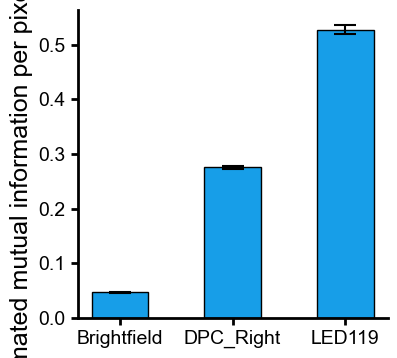

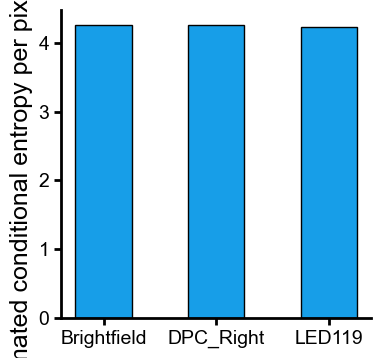

In [10]:
# set the width of the bars
bar_width = 0.35


# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))


# create the bar plots
bar_width = 0.5
lower_errors = mi_means - mi_confidences[:, 0]
upper_errors = mi_confidences[:, 1] - mi_means

# Calculate the positions where the bars should be placed to be centered on the ticks
positions = np.arange(len(channel_names)) + 0.5 * bar_width

ax.bar(
    positions,
    mi_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw={'capsize': 8, 'capthick': 1.5}
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated mutual information per pixel (bits)')
clear_spines(ax)

# make another plot for conditional entropy
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

lower_errors = h_y_given_x_means - h_y_given_x_confidences[:, 0]
upper_errors = h_y_given_x_confidences[:, 1] - h_y_given_x_means

ax.bar(
    positions,
    h_y_given_x_means,
    # yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    color=colors[0],
    edgecolor='k',
    linewidth=1,
    error_kw={'capsize': 8, 'capthick': 1.5}
)

# add labels, title, and legend
ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
ax.set_ylabel('Estimated conditional entropy per pixel (bits)')
clear_spines(ax)